# Business Problem:
 ### Walmart needs accurate weekly sales forecasts to optimize inventory, staffing, and promotional planning.

# Objective:
 ### Build a machine learning model to forecast weekly sales for 2013 using historical store and economic data.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [3]:
# loading the datasets

features = pd.read_csv("datasets/features.csv")

stores = pd.read_csv("datasets/stores.csv")

train = pd.read_csv("datasets/train.csv")

test = pd.read_csv("datasets/test.csv")

#### converting the date column into datetime

In [5]:
for i in [train, features]:
    i["Date"] = pd.to_datetime(i["Date"])

#### merging the data

In [6]:
df = train.merge(stores , on ='Store',how='left')
df = df.merge(features , on =['Store','Date'],how='left')

In [7]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
print(df.columns)
print(df.shape)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y'],
      dtype='object')
(421570, 17)


#### drop duplicate columns

In [9]:

df = df.drop(columns = ['IsHoliday_y'])

df=df.rename(columns={"IsHoliday_x":"IsHoliday"})

#### checking null values

In [10]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

In [11]:
df = df.sort_values(["Date",'Store','Dept'])
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
143,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
286,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
429,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
572,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


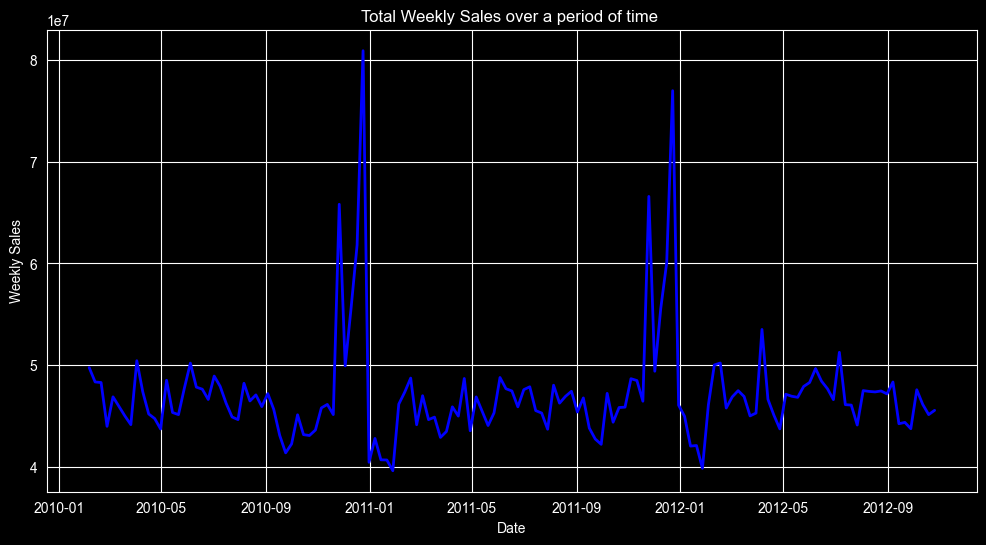

In [12]:
# plotting the target variable
total_weekely_sales = df.groupby("Date")['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.plot(total_weekely_sales['Date'],total_weekely_sales['Weekly_Sales'],color='blue', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.title("Total Weekly Sales over a period of time ")
plt.show()

#### IsHoliday Vs Weekly-Sales-Plot

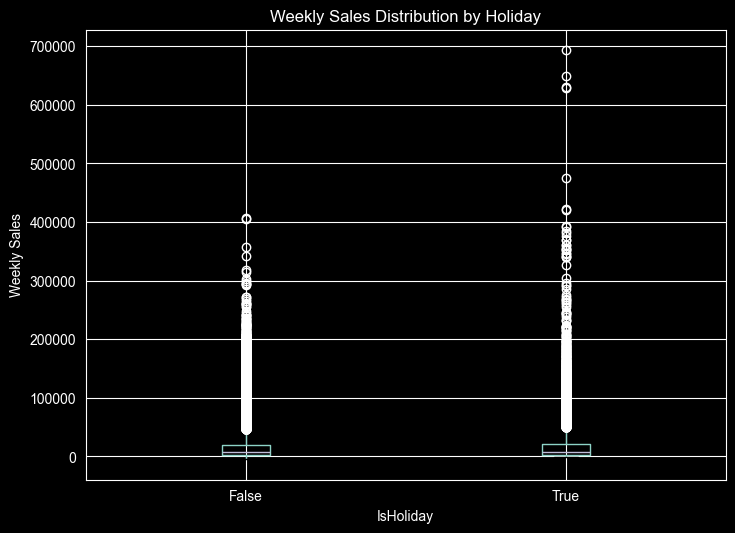

In [17]:
df.boxplot(column="Weekly_Sales", by="IsHoliday", figsize=(8,6))

plt.title("Weekly Sales Distribution by Holiday")
plt.suptitle("")  # Removes the automatic 'Boxplot grouped by ...' title
plt.xlabel("IsHoliday")
plt.ylabel("Weekly Sales")
plt.show()


## Feature Engineering

In [18]:
# date features
df['day'] = df['Date'].dt.day
df['week'] = df['Date'].dt.isocalendar().week
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

    # lag features
df['lag_1_week'] = df.groupby(["Store","Dept"])['Weekly_Sales'].shift(1)
df['lag_2_week'] = df.groupby(["Store","Dept"])['Weekly_Sales'].shift(2)
df['lag_1_month'] = df.groupby(["Store","Dept"])['Weekly_Sales'].shift(4)

    # rooling mean of the last 4 weeks
df['rolling_4_week'] = df.groupby(["Store","Dept"])['Weekly_Sales'].transform(lambda x:x.shift(1).rolling(window=4).mean())

    # total markdown feature
df['total_markdown'] = df['MarkDown1'] + df['MarkDown2'] + df['MarkDown3'] + df['MarkDown4'] + df['MarkDown5']

In [19]:
df = df.dropna(subset=['lag_1_week','lag_2_week','lag_1_month','rolling_4_week'])

for col in ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']:
    df[col] = df[col].fillna(0)

C:\Users\kaush\AppData\Local\Temp\ipykernel_4452\1900925960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(0)


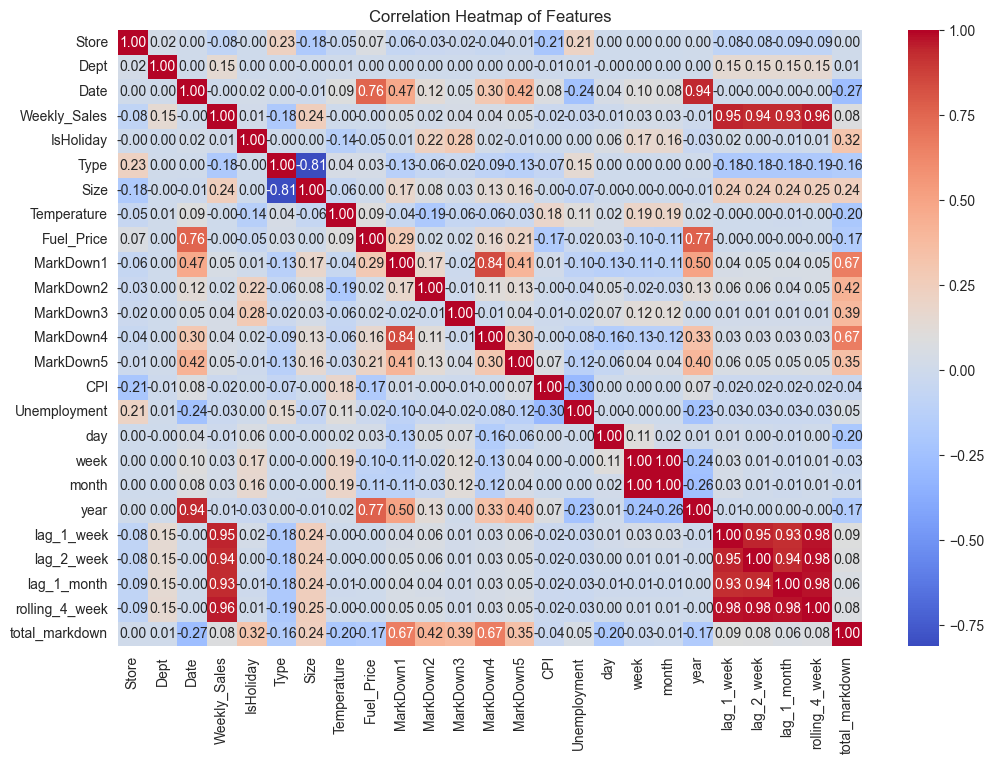

In [41]:

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Correlation Heatmap of Features")
plt.show()


C:\Users\kaush\AppData\Local\Temp\ipykernel_4452\2970828321.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


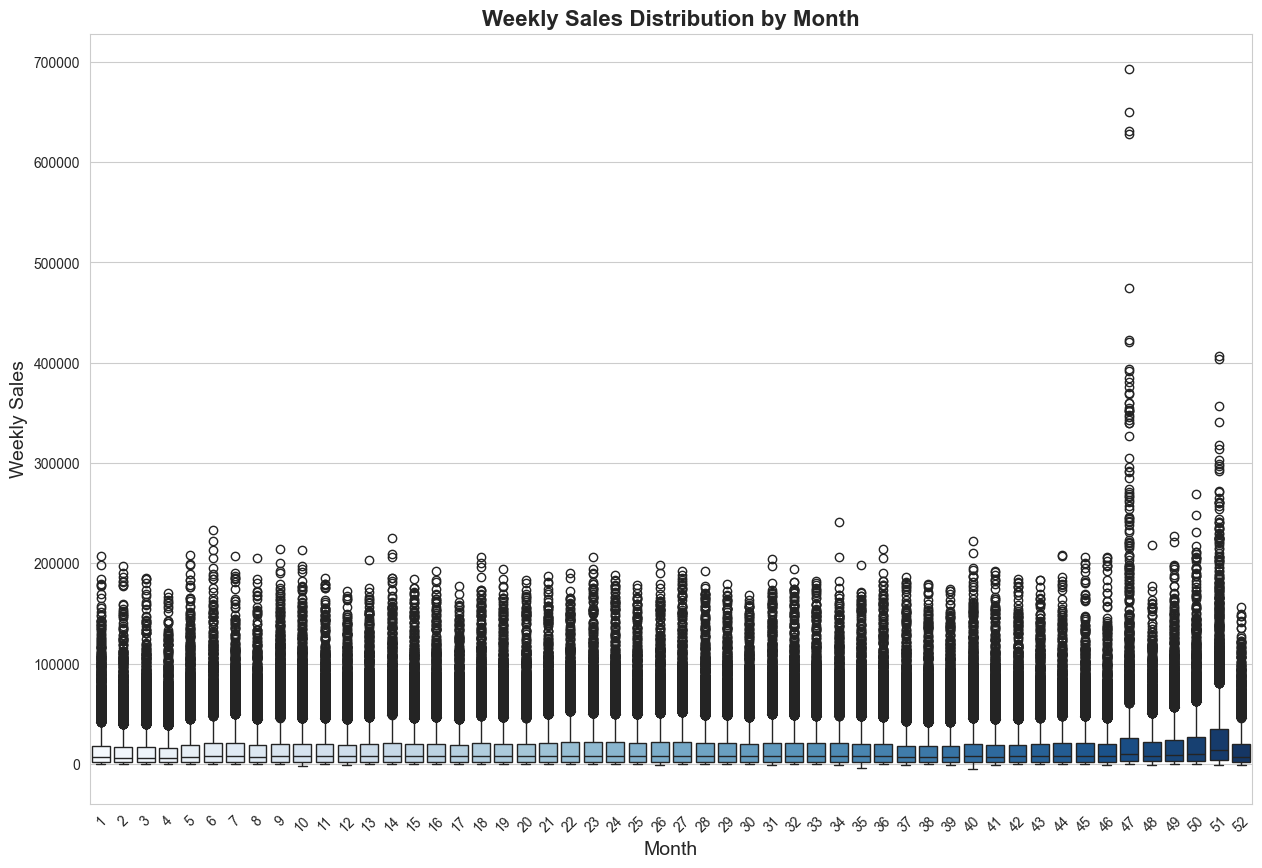

In [21]:
sns.set_style("whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(
    data=df,
    x='week',
    y='Weekly_Sales',
    palette='Blues'
)

# Titles and labels
ax.set_title("Weekly Sales Distribution by Month", fontsize=16, fontweight='bold')
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Weekly Sales", fontsize=14)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

plt.show()

### Encoding the Type column

In [22]:
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])

df['IsHoliday'] = df['IsHoliday'].astype(int)

C:\Users\kaush\AppData\Local\Temp\ipykernel_4452\460819458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type'] = le.fit_transform(df['Type'])
C:\Users\kaush\AppData\Local\Temp\ipykernel_4452\460819458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsHoliday'] = df['IsHoliday'].astype(int)


#### train-test=split

In [28]:
train = df.loc[df['Date'] < "2012-01-01"]
test  = df.loc[df['Date'] >= "2012-01-01"]

##### dependent and independent variable

In [25]:
 # train dataset
X_train = train.drop(columns =['Weekly_Sales','Date'])
y_train = train['Weekly_Sales']

# test dataset
X_test = test.drop(columns =['Weekly_Sales','Date'])
y_test = test['Weekly_Sales']

#### creating a model

In [27]:
reg = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.05,eval_metric= 'rmse',early_stopping_rounds=50)

reg.fit(X_train,y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=True)

[0]	validation_0-rmse:21929.06965	validation_1-rmse:21055.69544
[1]	validation_0-rmse:20928.22822	validation_1-rmse:20031.09864
[2]	validation_0-rmse:19982.40896	validation_1-rmse:19057.70095
[3]	validation_0-rmse:19084.80947	validation_1-rmse:18135.83880
[4]	validation_0-rmse:18234.54766	validation_1-rmse:17260.14397
[5]	validation_0-rmse:17431.60054	validation_1-rmse:16432.29085
[6]	validation_0-rmse:16672.49848	validation_1-rmse:15648.36227
[7]	validation_0-rmse:15956.97851	validation_1-rmse:14906.50204
[8]	validation_0-rmse:15280.82946	validation_1-rmse:14201.12229
[9]	validation_0-rmse:14642.91060	validation_1-rmse:13533.80640
[10]	validation_0-rmse:14035.91791	validation_1-rmse:12907.74477
[11]	validation_0-rmse:13468.50225	validation_1-rmse:12316.62637
[12]	validation_0-rmse:12931.60562	validation_1-rmse:11749.29317
[13]	validation_0-rmse:12423.00008	validation_1-rmse:11218.73779
[14]	validation_0-rmse:11945.16280	validation_1-rmse:10721.04785
[15]	validation_0-rmse:11498.38137	

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

## WMAE Calculation

In [36]:
y_pred =reg.predict(X_test)



In [32]:
def wmae(y_test, y_pred, is_holiday):

    # Assign weights: holiday weeks = 5, normal weeks = 1
    weights = np.where(is_holiday == 1, 5, 1)

    # Compute weighted absolute errors
    weighted_errors = weights * np.abs(y_test - y_pred)

    # Final WMAE = sum of weighted errors / sum of weights
    return weighted_errors.sum() / weights.sum()


is_holiday = test['IsHoliday'].values    # directly use the IsHoliday column

error = wmae(y_test, y_pred, is_holiday)
print("WMAE:", error)

WMAE: 1573.7256622105735


In [33]:
# feature importance
importance = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])

<Axes: >

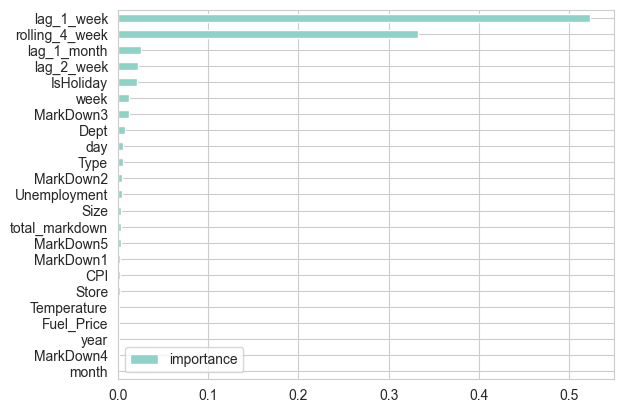

In [34]:
importance.sort_values('importance').plot(kind='barh')

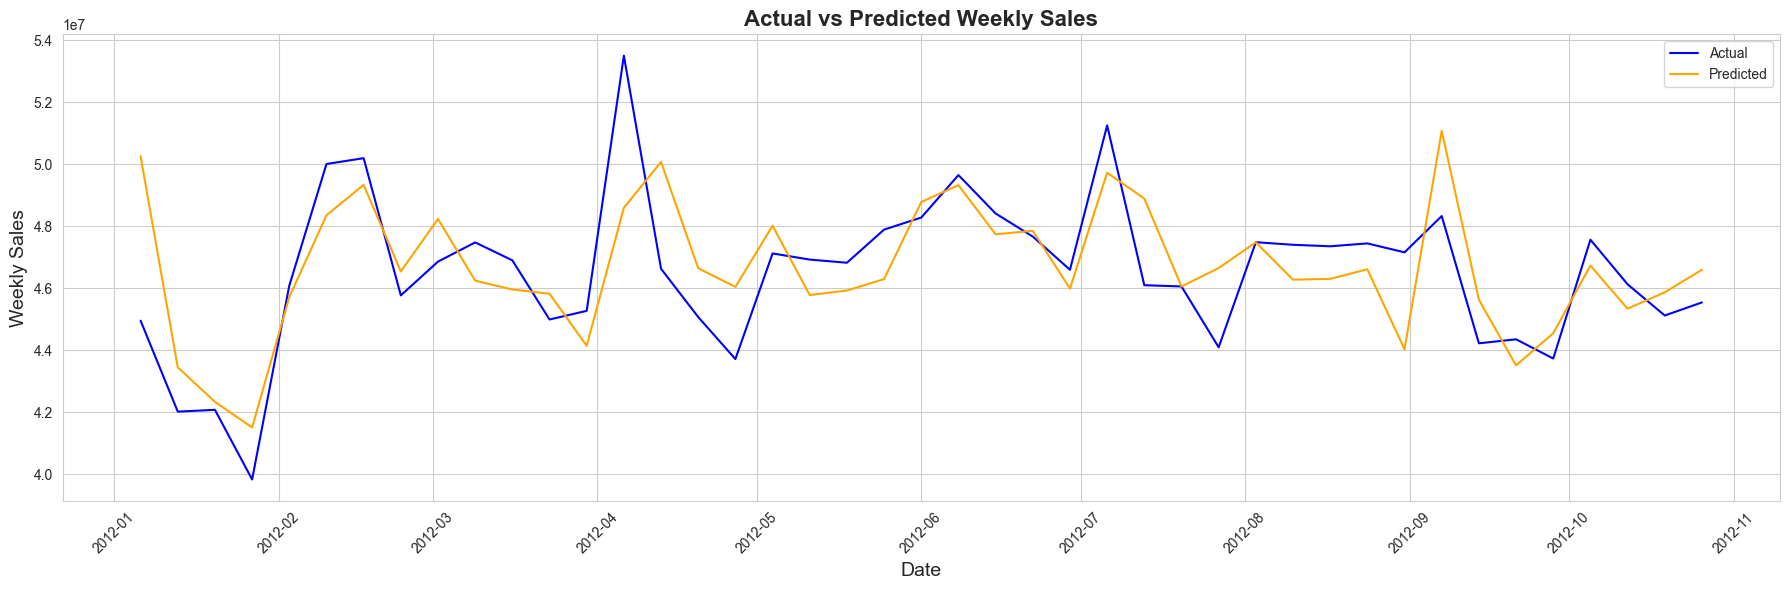

In [37]:
# Group and sum actual and predicted sales by Date
sum_weekly = test.groupby('Date')['Weekly_Sales'].sum().reset_index()
sum_pred = test.groupby('Date')['y_pred'].sum().reset_index()

# Merge so both series align on Date
merged = sum_weekly.merge(sum_pred, on='Date')

# Plot with Date on x-axis
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(merged['Date'], merged['Weekly_Sales'], label='Actual', linestyle='-', color='blue')
ax.plot(merged['Date'], merged['y_pred'], label='Predicted', linestyle='-', color='orange')

# Formatting
ax.set_title('Actual vs Predicted Weekly Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Weekly Sales', fontsize=14)
ax.legend()

plt.xticks(rotation=45)  # rotate dates for readability
plt.tight_layout()
plt.show()

In [38]:
import pickle

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le,f)

with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(reg,f)

In [39]:
df.to_csv("final-walmart.csv",index=False)